In [0]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/' 
train_test_set = pd.read_csv(root_path + 'data/predict_future_sales/train_test_set_basic_lags.csv')
train_test_set.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Unnamed: 0,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_12,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_12,prev_shopitem_price_1,prev_shopitem_price_2,prev_shopitem_price_3,prev_shopitem_price_12,prev_item_price_1,prev_item_price_2,prev_item_price_3,prev_item_price_12
0,0,0,1,22154,999.0,59,11,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,5,22154,999.0,25,11,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,1,22154,999.0,24,11,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,22154,NaN,23,11,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,0,22154,NaN,19,11,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
train_test_set.drop(columns='Unnamed: 0', inplace=True)

In [0]:
for col in train_test_set.columns:
  train_test_set[col].fillna(0, inplace=True)

In [30]:
train_test_set.head()

,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_12,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_12,prev_shopitem_price_1,prev_shopitem_price_2,prev_shopitem_price_3,prev_shopitem_price_12,prev_item_price_1,prev_item_price_2,prev_item_price_3,prev_item_price_12
0,0,1,22154,999.0,59,11,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5,22154,999.0,25,11,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,22154,999.0,24,11,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,22154,0.0,23,11,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,22154,0.0,19,11,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create validation set

In [0]:
small_df = train_test_set[train_test_set['date_block_num'] <= 33].sample(frac=0.2, random_state=42)
small_df = small_df.reset_index()
test_df = train_test_set[train_test_set['date_block_num'] == 34]
test_df = test_df.reset_index()

In [0]:
#import fastai
from fastai.tabular import *

procs=[Categorify, Normalize]
cat_vars = ['item_id', 'shop_id', 'item_category_id']
cont_vars = ['date_block_num', 'item_price', 'prev_shopitem_sales_1', 'prev_shopitem_sales_2', 'prev_shopitem_sales_3',
             'prev_shopitem_sales_12', 'prev_item_sales_1', 'prev_item_sales_2', 'prev_item_sales_3', 'prev_item_sales_12',
       'prev_shopitem_price_1', 'prev_shopitem_price_2',
       'prev_shopitem_price_3', 'prev_shopitem_price_12', 'prev_item_price_1',
       'prev_item_price_2', 'prev_item_price_3', 'prev_item_price_12']

valid_idx = small_df[small_df['date_block_num'] == 33].index.values
test_idx = small_df[small_df['date_block_num'] == 34].index.values

In [0]:
dep_var = 'item_cnt_month'

path = 'gdrive/My Drive/Colab Notebooks/data/predict_future_sales'
data = (TabularList.from_df(small_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(test_df, path=path))
                .databunch())

In [0]:
emb_szs= {
            'shop_id': 5,
            'item_id': 12,
            'item_category_id': 3,
        }

In [0]:
y_range = torch.tensor([0, 20.5], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[300,150], ps=[0.001,0.01], emb_drop=0.15, y_range=y_range, metrics=rmse)

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


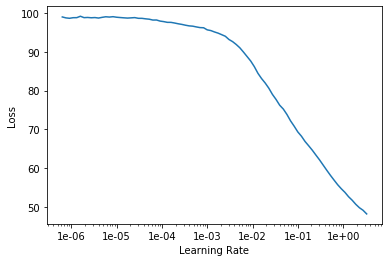

In [54]:
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(4, 1e-2, wd=0.1)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.917222,0.867696,0.750305,03:33
1,0.943504,1.335726,0.861138,03:32
2,0.716509,0.943180,0.773505,03:33
3,0.506861,0.975281,0.814337,03:32


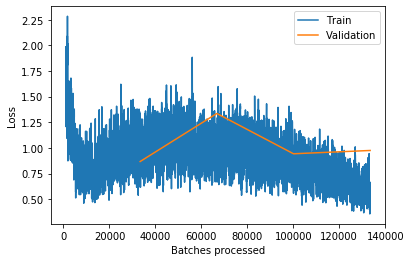

In [63]:
learn.recorder.plot_losses(skip_start=1000)

In [64]:
preds = learn.get_preds(ds_type=DatasetType.Test)[0].numpy()

In [50]:
preds.shape

(214200, 1)

In [65]:
from sklearn.metrics import mean_squared_error


y_true = test_df['item_cnt_month']
np.sqrt(mean_squared_error(preds, y_true))

1.6678351621341907